In [1]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
import numpy as np

# Logistic Regression on PCA features

In [2]:
df = spark.read.load("credit_pca_feats.parquet")
df.createOrReplaceTempView("credit")

In [3]:
df.printSchema()

root
 |-- label: double (nullable = true)
 |-- pca_features: vector (nullable = true)



In [4]:
lr = LogisticRegression(maxIter=40, featuresCol="pca_features")
lrmod = lr.fit(df)

In [5]:
print(lrmod.coefficients)
print(lrmod.intercept)

[-3.32894285059,0.335811900942,1.38012744608,-0.669157651127,0.232392134019,0.526443353882,0.601203658304,-0.683401009196,1.29312030135,-1.91496729027]
-2.46480699983


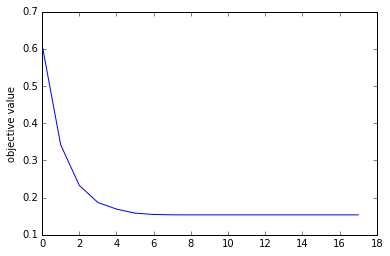

In [6]:
lrsum = lrmod.summary
pred = lrsum.predictions;
pred.createOrReplaceTempView("pr")
plt.plot(lrsum.objectiveHistory)
plt.ylabel('objective value')

In [7]:
t = spark.sql("SELECT COUNT(*)/1000000 AS accuracy from pr WHERE label=prediction")
t.show()

+--------+
|accuracy|
+--------+
|0.945546|
+--------+



- The accuracy of logistic with PCA features is < 95%. 
- Moreover, logistic regression + PCA is not easy to interpret. 

Hence attempt logistic without PCA.

# Logistic Regression with raw features

In [8]:
df2 = spark.read.load("credit_feats.parquet")
df2.createOrReplaceTempView("credit")
lr2 = LogisticRegression(maxIter=40, featuresCol="features")
lrmod2 = lr2.fit(df2)
lrsum2 = lrmod2.summary
pred2 = lrsum2.predictions;
pred2.createOrReplaceTempView("pr2")

## Diagnosis

To diagnose the model, we look at 3 aspects

1. Whether the objective function value has stabilized.
2. Accuracy over 95%.
3. Coefficients and intercept are reasonable.

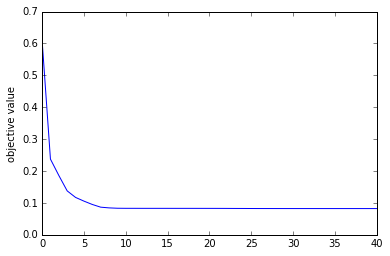

In [9]:
plt.plot(lrsum2.objectiveHistory)
plt.ylabel('objective value')

In [10]:
t2 = spark.sql("SELECT COUNT(*)/1000000 AS accuracy from pr2 WHERE label=prediction")
t2.show()

+--------+
|accuracy|
+--------+
|0.977683|
+--------+



In [11]:
t2 = spark.sql("SELECT label, COUNT(*) FROM pr2 GROUP BY label")
t2.show()

+-----+--------+
|label|count(1)|
+-----+--------+
|  0.0|  700000|
|  1.0|  300000|
+-----+--------+



In [12]:
print("Coefficients: ", lrmod2.coefficients.toArray())
print("Intercept : {:.3f}".format(lrmod2.intercept))
# help(lrmod2.coefficients)

('Coefficients: ', array([ 1.14403338,  1.33500762,  1.06110395,  1.99217313,  1.99551832,
        2.51582736,  1.67190549,  3.63173218, -0.71847031, -1.24197449,
        2.0028136 ,  0.13242339,  3.77530029,  2.4281986 , -0.14244171,
       -0.54004825, -0.35967478, -1.96716181,  0.97338233, -0.87574591,
        0.31493134, -1.37428984, -0.81506168, -1.88334015, -5.17181967,
       -6.50789292, -2.80341416, -6.41773454,  0.49768324, -5.84713315,
        0.06775389, -2.28714324, -0.68754703]))
Intercept : -0.035


## Interpretation

The logistic regression model is fit with the following sigmoidal link function (https://spark.apache.org/docs/2.1.3/mllib-linear-methods.html#logistic-regression)

$$f(z) = \frac{1}{1+e^{-z}}$$

Here $z$ is the $w^Tx$ or the linear combination of the predictors. $f(z)$ is the probability of defaulting. If $f(z) < 0.5$, then the prediction is 0 (does not default). Else prediction is 1 (will default). We consider the odds ratio of this probability for interpretability:

$$OR = \frac{f(z)}{1-f(z)} = e^z$$

In a traditional statistical modeling software, each coefficient also has a t-statistic or p-value that helps decide if it is significant or not. Spark 2.1.3 doesn't output this, so we might at this juncture just assume every coefficient is significantly different from zero. Hence, every feature matters.

### Intercept

The intercept is -0.035. So we $OR = e^{-0.035} = 0.96$. It is interpreted as "A person has 0.96:1 odds of (defaulting:not defaulting) when all their covariates are 0". 

This needs to be unpacked a little. One must look at what each covariate being 0 means in order for a full interpretation. From the ETL script, we know that the covariates are 0 in the 'base' case, and this 'base' case is given by the `feat_base_full` list saved in `feat_names.npz`.

In [13]:
with np.load("feat_names.npz") as f:
    feat_base_full = f["feat_base_full"]
    feat_names_full = f["feat_names_full"]
    mean_quant_feats = f["mean"]
    std_quant_feats = f["std"]
print(feat_base_full)

[u'ACCOUNT_AGE(1 to 4 YRS)' u'ACCOUNT_TYPE(500 to 1000 K USD)'
 u'CREDIT_HISTORY(CRITICAL ACCOUNT)' u'HAS_CO_APPLICANT(YES)'
 u'HAS_GUARANTOR(YES)' u'IS_STATE_BORDER(YES)' u'IS_URBAN(NO)'
 u'OTHER_INSTALMENT_PLAN(YES)' u'OWN_CAR(NO)' u'OWN_REAL_ESTATE(YES)'
 u'OWN_RESIDENCE(YES)' u'SHIP_INTERNATIONAL(NO)' u'STATE(NJ)'
 u'TRANSACTION_CATEGORY(OTHER)' u'rfm = 3.55'
 u'transaction amount = 26980.0' u'emi tenure = 109.68']


### Example covariate

#### Qualitative variable

The first coefficient is 1.1440. So we have $OR = e^{1.144} = 3.13$. From the ETL, we know that the first covariate is `ACCOUNT_AGE(up to 1 YR)`. We also know that the base case is `ACCOUNT_AGE(1 to 4 YRS)` (see above).

Hence this coefficient is interpreted as "All other factors remaining the same, a person with an account age of up to 1 year has a 3.13 times higher odds (of defaulting:not defaulting) than a person with an account age of 1-4 years."

#### Quantitative variable

Another coefficient to consider is the last but one with a value of -2.29. So the $OR = 0.1$. This is the coefficient for scaled transaction amount. The interpretation for this coefficient is "All other factors remaining the same, an increase of 1 scaled trasaction amount unit (or = 4607.57 USD, see below) results in the odds (of defaulting:not defaulting) being multiplied by 0.1.". 

Put simply, $4500 increase in transaction value reduces the odds ratio (of defaulting:not defaulting) by 10. Higher transaction values are less likely to default in the future.

In [14]:
print("One scaled transaction amount unit is {:.2f} USD".format(std_quant_feats[1]))

One scaled transaction amount unit is 4607.57 USD


The following table illustrates all covariates and their odds ratio:

In [15]:
coeffs = lrmod2.coefficients.toArray()
coeffs.reshape(1, 33)
interpretation = pd.DataFrame(data = [np.round(coeffs,2), np.round(np.exp(coeffs),2), feat_names_full]).transpose()
interpretation.columns = ["Log odds ratio", "Odds ratio", "Feature"]
interpretation

,Log odds ratio,Odds ratio,Feature
0,1.14,3.14,ACCOUNT_AGE(up to 1 YR)
1,1.34,3.8,ACCOUNT_AGE(above 7 YRS)
2,1.06,2.89,ACCOUNT_AGE(4 to 7 YRS)
3,1.99,7.33,ACCOUNT_AGE(TBD)
4,2,7.36,ACCOUNT_TYPE(above 1000 K USD)
5,2.52,12.38,ACCOUNT_TYPE(UNKNOWN/NONE)
6,1.67,5.32,ACCOUNT_TYPE(100 to 500 K USD)
7,3.63,37.78,ACCOUNT_TYPE(up to 100 K USD)
8,-0.72,0.49,CREDIT_HISTORY(EXISTING CREDITS PAID BACK)
9,-1.24,0.29,CREDIT_HISTORY(ALL CREDITS PAID BACK)


#### Interesting

- Accounts with <100k have 37 times higher odds of defaulting:not defaulting compared to accounts with 500-1000k.
- Accounts without co-applicants have 43 times higher odds of defaulting:notdefaulting compared to accounts with a co-applicant.
- Applicants getting new/used cars or electronics are much less likely to default than those in the "OTHER" category.


# Benchmark with a random guess

Randomly guessing whether the person will default or not will result in correct guesses 50% of the time. This is independent of the proportion of `IS_DEFAULT` since we have by Bayes' theorem:

$$P(A|B) = \frac{P(A\cap B)}{P(B)}$$
Now with $A = correct guess$ and $B = IS DEFAULT is No$, we have 

$$P(A\cap B) = P(correct guess \cap IS DEFAULT is No) = P(correct guess)P(IS DEFAULT is No)$$

since $correct guess$ and $ISDEFAULT is No$ are independent events. We also have:

$$P(B) = P(ISDEFAULT is No)$$

So we have $P(correct guess | IS DEFAULT is No) = P(correct guess) = 0.5$

This is numerically verified below:

In [16]:
n = 10000
a = np.hstack([np.ones(int(0.7*n)), np.zeros(int(0.3*n))])
b = np.round(np.random.rand(n))
print("Probability of correct guess = {:.2f}".format(np.sum(a==b)*1.0/n))

Probability of correct guess = 0.49
